In [26]:
%matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

from dataclasses import dataclass

In [15]:
# set up dynamics

def calc_interia(mass, dims):  # about the tip of the pen
    # pen, solid cylinder http://hyperphysics.phy-astr.gsu.edu/hbase/icyl.html
    I_pen_central = mass['pen'] * (dims['pen_r']**2 / 4 + dims['pen_h']**2 / 12)
    # shift to edge of cylinder https://pressbooks.online.ucf.edu/osuniversityphysics/chapter/10-5-calculating-moments-of-inertia/
    I_pen = I_pen_central + mass['pen'] * (dims['pen_h']/2)**2
    # cube, solid cube https://en.wikipedia.org/wiki/List_of_moments_of_inertia
    I_cube_central = mass['cube'] * (dims['cube_a']**2 / 6)
    # shift to edge of cube https://pressbooks.online.ucf.edu/osuniversityphysics/chapter/10-5-calculating-moments-of-inertia/
    I_cube = I_cube_central + mass['cube'] * (dims['cube_a']/2 + dims['pen_h'])**2
    I = I_pen + I_cube
    center_of_mass = (mass['pen'] * dims['pen_h'] / 2 + mass['cube'] *
                      (dims['cube_a']/2 + dims['pen_h'])) / (mass['pen'] + mass['cube'])
    return I, center_of_mass


def get_mgl_I():
    DENSITY = {  # kg/m^3
        'aluminium': 2700,
        'iron': 7870,
    }
    DIMS = {  # m
        'pen_r': 5e-3,
        'pen_h': 2e-1,
        'cube_a': 5e-2,
    }
    MASS = {  # kg
        'pen': DENSITY['aluminium'] * np.pi * DIMS['pen_r']**2 * DIMS['pen_h'],
        'cube': DENSITY['aluminium'] * DIMS['cube_a']**3,
    }
    I, center_of_mass = calc_interia(MASS, DIMS)
    return ((MASS['pen'] + MASS['cube']) * sp.constants.g * center_of_mass) / I


mgl_I = get_mgl_I()


def xdot_pen(t, x):
    return np.array([x[1], mgl_I * x[0]])

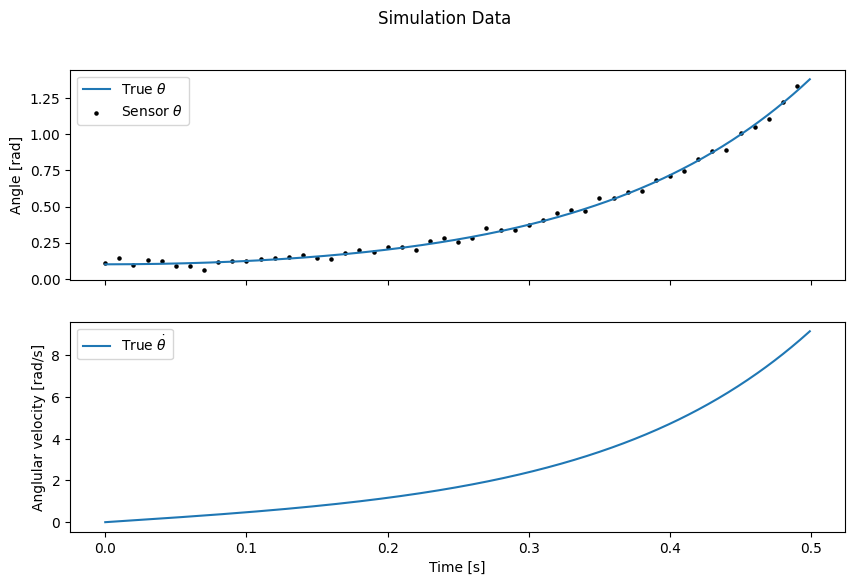

In [52]:
# simulate system
X0 = np.array([0.1, 0])
Tstart = 0
Tend = 0.5
Tstep = 0.001  # 1ms
sens_interval = 10  # every 10th step
sens_noise_std = 0.02


@dataclass
class Data:
    t: np.ndarray
    y: np.ndarray


def generate_sim_data(xdot, X0, Tstart, Tend, Tstep, sens_interval, sens_noise_std):
    sol = sp.integrate.solve_ivp(xdot, [Tstart, Tend], X0, t_eval=np.arange(Tstart, Tend, Tstep))
    truth = Data(sol.t, sol.y)
    sensor = Data(sol.t[::sens_interval],
                  # only measure angle, add noise
                  sol.y[0, ::sens_interval] + np.random.randn(1, len(sol.t[::sens_interval])) * sens_noise_std)
    # measure both, add noise
    #   sol.y[:, ::sens_interval] + np.random.randn(sol.y.shape[0], len(sol.t[::sens_interval])) * sens_noise_std)
    return truth, sensor


def plot_data(fignum, truth, sensor):
    plt.close(fignum)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), num=fignum, sharex=True)
    fig.suptitle('Simulation Data')
    axs[0].plot(truth.t, truth.y[0], label=r'True $\theta$')
    axs[0].set_ylabel('Angle [rad]')
    axs[0].scatter(sensor.t, sensor.y, marker='o', c='k', s=5, label=r'Sensor $\theta$')
    axs[0].legend()
    axs[1].plot(truth.t, truth.y[1], label=r'True $\dot{\theta}$')
    # plt.scatter(sensor.t, sensor.y[0], label='Sensor Angle')
    # plt.scatter(sensor.t, sensor.y[1], label='Sensor Angular Velocity')
    axs[1].set_xlabel('Time [s]')
    axs[1].set_ylabel('Anglular velocity [rad/s]')
    axs[1].legend()
    fig.savefig('figs/plot_data.svg')
    plt.show()
    return fignum + 1


truth, sensor = generate_sim_data(xdot_pen, X0, Tstart, Tend, Tstep, sens_interval, sens_noise_std)
fignum = 1
fignum = plot_data(fignum, truth, sensor)